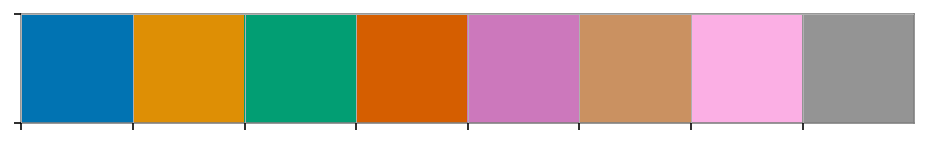

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
#import matplotlib.pyplot as P

golden_ratio = 1.61803398875
matplotlib.rcParams['figure.figsize'] = (10, 10/golden_ratio)

import gwsurrogate

from tqdm import tqdm

from bilby.core.utils import nfft, infft

from scipy import interpolate
from scipy import stats


import seaborn as sns

cp = sns.color_palette('colorblind', 8)
sns.palplot(cp)
plt.show()

Load the surrogate, this should only be done once

In [4]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
#trunc_sur = gwsurrogate.LoadSurrogate('../TruncatedSurrogate/NRHybSur3dq8.h5')
trunc_sur = gwsurrogate.LoadSurrogate('/home/carl-johan.haster/projects/Waveform_marginalisation/TruncatedSurrogate/NRHybSur3dq8.h5')

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model
Loaded NRHybSur3dq8 model


In [5]:
def find_nearest_index(value, array):
    return np.argmin(np.absolute(value - array))

def find_nearest_indices(values, array):
    return np.absolute(np.subtract.outer(array, values)).argmin(0)

In [6]:
#q = 5
#chiA = [0, 0, 0.8]
#chiB = [0, 0, -0.7]
#M = 30             # Total masss in solar masses
q = 7
chiA = [0, 0, 0.5]
chiB = [0, 0, -0.7]
M = 60             # Total masss in solar masses
dist_mpc = 100     # distance in megaparsecs
dt = 1./4096       # step size in seconds
f_low = 20         # initial frequency in Hz
inclination = np.pi/4
phi_ref = np.pi/5


For more options such as using only a subset of modes, see https://data.black-holes.org/surrogates/NRHybSur3dq8.html

In [7]:
# Returns h_+ -i h_x
t, h, _ = sur(q, chiA, chiB, dt=dt, f_low=f_low, M=M, dist_mpc=dist_mpc,
           inclination=inclination, phi_ref=phi_ref, units='mks')

In [8]:
# Returns h_+ -i h_x
t_trunc, h_trunc, _ = trunc_sur(q, chiA, chiB, dt=dt, f_low=f_low, M=M, \
    dist_mpc=dist_mpc, inclination=inclination, phi_ref=phi_ref, units='mks')

Only working with h_plus for now, but plan is to do the same treatment below to h_cross as well

Could consider tying them together (ie restrict h_cross to be h_plus rotated 45 degrees), but I think it's more general to keep them separate

In [9]:
h_plus_diff = h.real-h_trunc.real

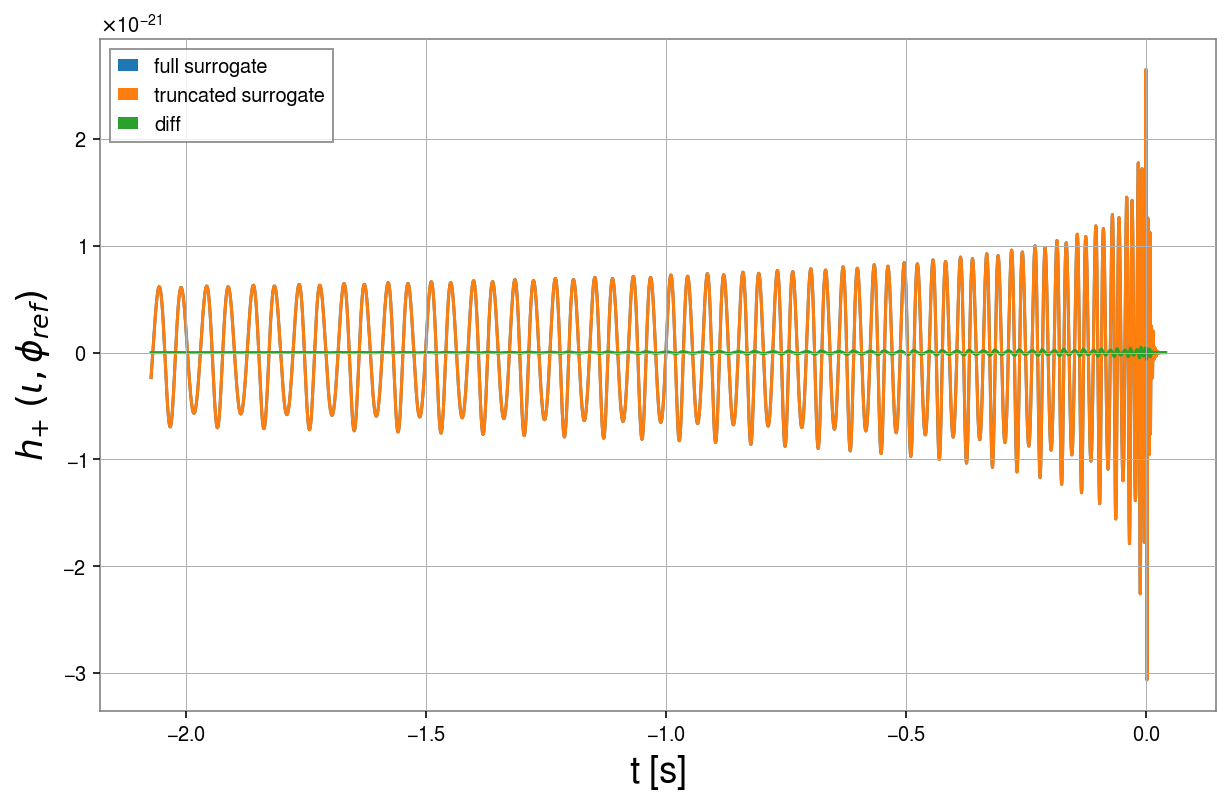

In [10]:
plt.plot(t, h.real, label='full surrogate')
plt.plot(t_trunc, h_trunc.real, label='truncated surrogate')
plt.plot(t, h_plus_diff, label='diff')
plt.legend(loc='best')
plt.ylabel('$h_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('t [s]', fontsize=18)
plt.show()

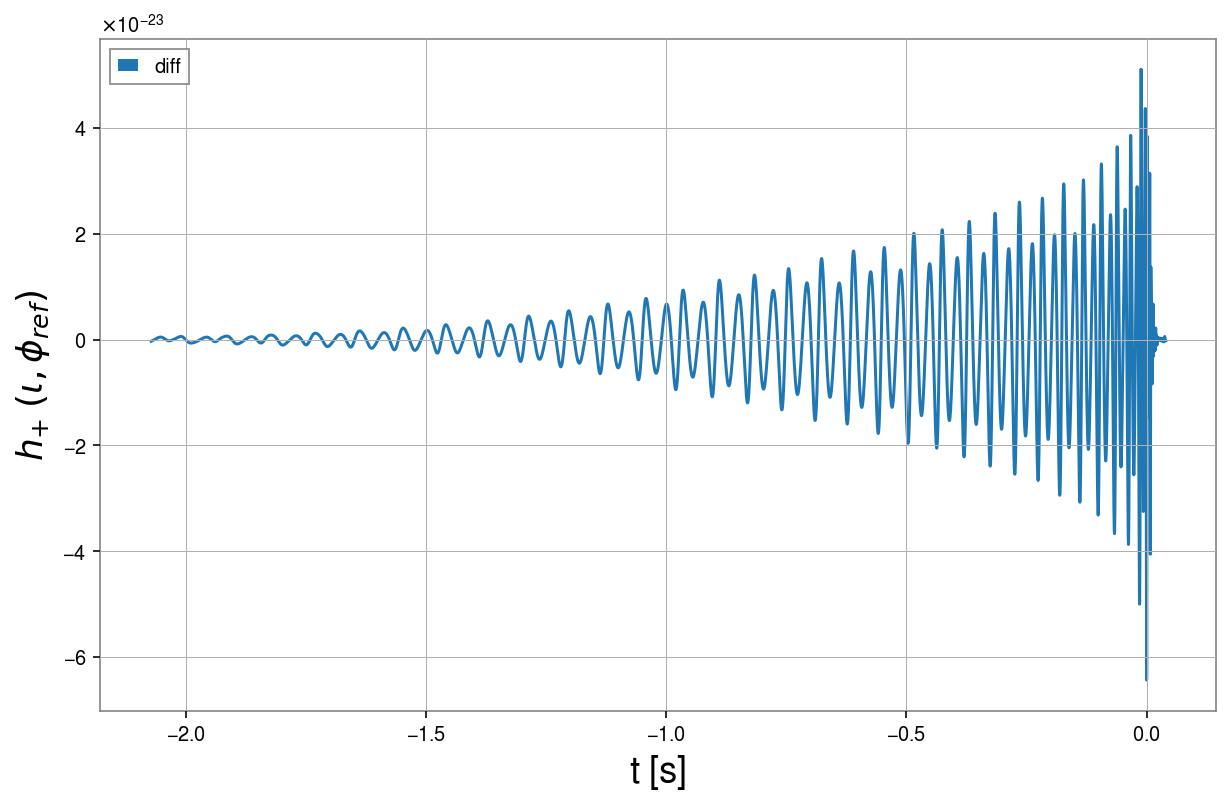

In [11]:
plt.plot(t, h_plus_diff, label='diff')
plt.legend(loc='best')
plt.ylabel('$h_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('t [s]', fontsize=18)
#plt.xscale('log')
plt.show()

It's easier to work with the Freq-domain properties, rather than the raw time-domain diff.

So I take a FFT of the diff waveform

In [12]:
h_plus_diff_fft, h_plus_diff_freq = nfft(h_plus_diff, sampling_frequency=1/dt)

Extract the amplitude and phase of the FD diff

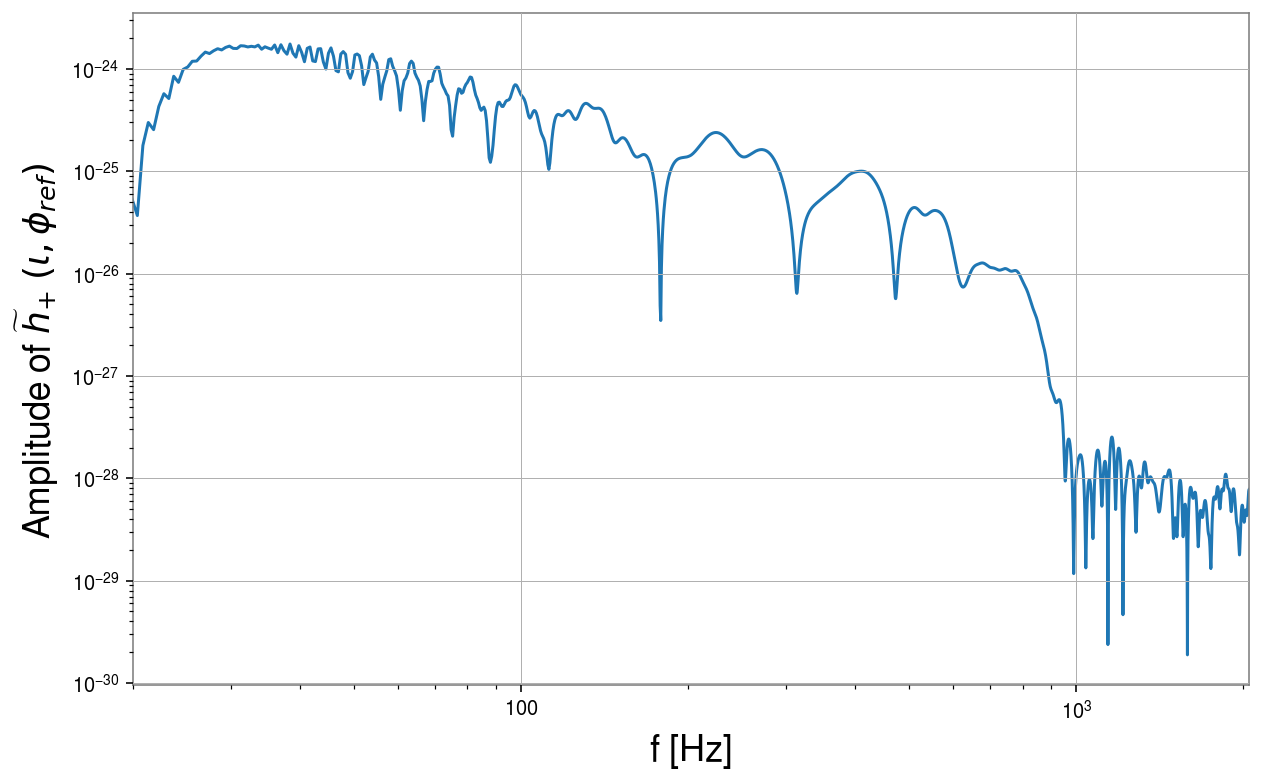

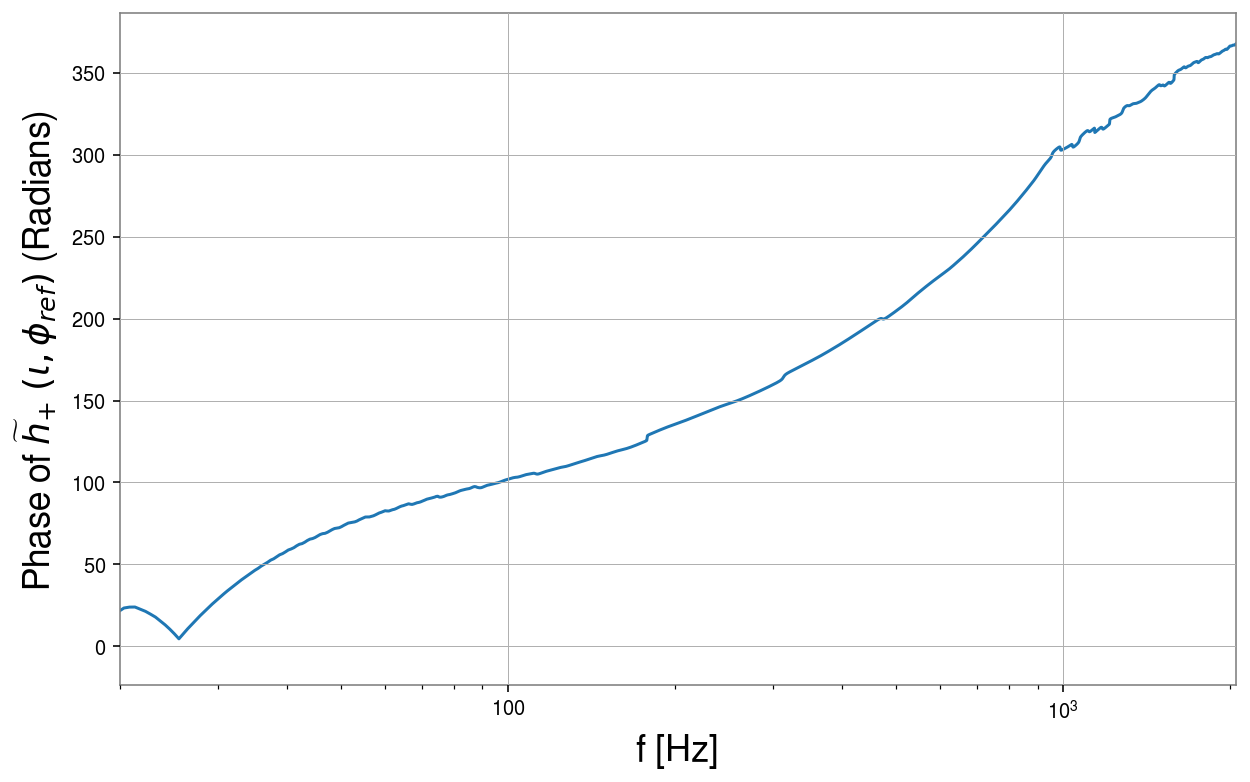

In [13]:
Raw_diff_amp = np.absolute(h_plus_diff_fft)
Raw_diff_phase = np.unwrap(np.angle(h_plus_diff_fft))

plt.loglog(h_plus_diff_freq, Raw_diff_amp)
plt.ylabel('Amplitude of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
plt.show()

plt.semilogx(h_plus_diff_freq, Raw_diff_phase)
plt.ylabel('Phase of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$ (Radians)', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
plt.show()

Want to use these amplitude and phases as a guide for the actual modification we're to add to the main WF, so we want to sample in a region centered at these lines.

First step is to pick a number of points we're to sample

In [14]:
# we know there are len(h_plus_diff) points of information in the original diff, so let's pick every 100 point to sample at, and then interpolate in between (later)
Num_Select_raw = int(len(h_plus_diff)/100.)

# Pick points equally spaced in log_Freq (useful and reasonably agnostic spacing for CBC chirps)
f_select_array = np.logspace(np.log10(h_plus_diff_freq[1]), np.log10(h_plus_diff_freq[-1]), Num_Select_raw)

# Find the indeces for these points in the array which actually represents the WF we have
f_select_array_indeces_raw = find_nearest_indices(f_select_array, h_plus_diff_freq)

# remove duplicate index entries, this removes a non-negligeble fraction of points, but primarily at the low-freq side where we don't care too much anyways.
f_select_array_indeces = np.array(list(dict.fromkeys(f_select_array_indeces_raw.tolist())))

#print(f_select_array_indeces_raw)
#print(f_select_array_indeces)
print('original number of points: ',f_select_array_indeces_raw.shape[0], ', new number of points:', f_select_array_indeces.shape[0])

Num_Select = len(f_select_array_indeces)

original number of points:  86 , new number of points: 72


### NOTE

in this cell I define the scatter around the diff we'll consider.

As a baseline I say that everything is a Gaussian centered at the "true" amplitude and phase of the diff.

For the Amplitude, I say that the StandardDeviation is a third of the amplitude. 
Can consider this to be defined differently, for example to define the scatter in terms of the log_amplitude

For the phase I set the StandardDeviation to be 1 radian consistently


In [15]:
Amp_mean = np.zeros(Num_Select)
Amp_std = np.zeros(Num_Select)

Phase_mean = np.zeros(Num_Select)
Phase_std = np.zeros(Num_Select)
 
for i in tqdm(range(Num_Select)):
    
    ith_index = f_select_array_indeces[i]
              
    Amp_mean[i] = Raw_diff_amp[ith_index]
    Amp_std[i] = Raw_diff_amp[ith_index]/3.
    
    Phase_mean[i] = Raw_diff_phase[ith_index] 
    Phase_std[i] = 1.

100%|██████████| 72/72 [00:00<00:00, 64212.18it/s]


In [16]:
Amp_mean_bop = Raw_diff_amp[f_select_array_indeces]

print(Amp_mean, Amp_mean_bop)
print

[6.76687497e-27 1.60589146e-26 1.78650731e-26 1.05560986e-26
 1.93205258e-26 9.43653000e-27 1.49307655e-26 1.41380238e-26
 9.03254189e-27 6.70316468e-27 7.52172359e-27 1.18154398e-26
 4.47921365e-27 2.61187922e-26 1.27115090e-26 9.51310893e-27
 1.38127372e-26 2.44205076e-26 1.00445019e-25 7.89442965e-26
 8.97421979e-26 8.07211660e-26 8.03137359e-26 1.15618221e-25
 5.51048813e-26 4.29772796e-25 7.39453960e-25 1.46090530e-24
 1.67135334e-24 1.66456168e-24 1.71389777e-24 1.68713869e-24
 1.17252020e-24 1.38973618e-24 1.30745307e-24 9.61158908e-25
 7.74689535e-25 7.24494457e-25 7.06437102e-25 1.35308688e-25
 6.30904334e-25 3.70481044e-25 3.51368712e-25 4.51473880e-25
 2.90342454e-25 1.59141053e-25 6.25109514e-26 1.33515699e-25
 1.94476345e-25 2.06248988e-25 1.46584166e-25 1.31001498e-25
 8.31170454e-27 5.40240383e-26 8.61486714e-26 9.36675846e-26
 1.30543315e-26 4.34746053e-26 3.93841796e-26 7.47266365e-27
 1.18721385e-26 1.05583420e-26 3.98875476e-27 5.87190115e-28
 1.27629543e-28 9.762385

<function print>

Draw new diff points (to which we'll anchor the cubic spline later on!) from each Gaussian.

For the amplitude I create a truncated Gaussian, since we don't want negative amplitudes. (Also define an upper bound at 5 times the mean, but this doesn't make much difference overall I think).

Create 10 separate diffs, just to see what the spread can be

In [17]:
Ndraws = 10

Amp_Gauss = np.zeros((Num_Select, Ndraws))
Phase_Gauss = np.zeros((Num_Select, Ndraws))

for i in tqdm(range(Num_Select)):
    
    low, high = 0., 5*Amp_mean[i]
    low_a = (low-Amp_mean[i])/Amp_std[i]
    high_b = (high-Amp_mean[i])/Amp_std[i]
    
    Amp_Gauss[i] = stats.truncnorm.rvs(a=low_a, b=high_b, loc = Amp_mean[i], scale=Amp_std[i], size=Ndraws)
    
    Phase_Gauss[i] = stats.norm.rvs(loc = Phase_mean[i], scale=Phase_std[i], size=Ndraws)

100%|██████████| 72/72 [00:00<00:00, 2615.20it/s]


Plot scatter around the amplitude (only one of the 10 draws)

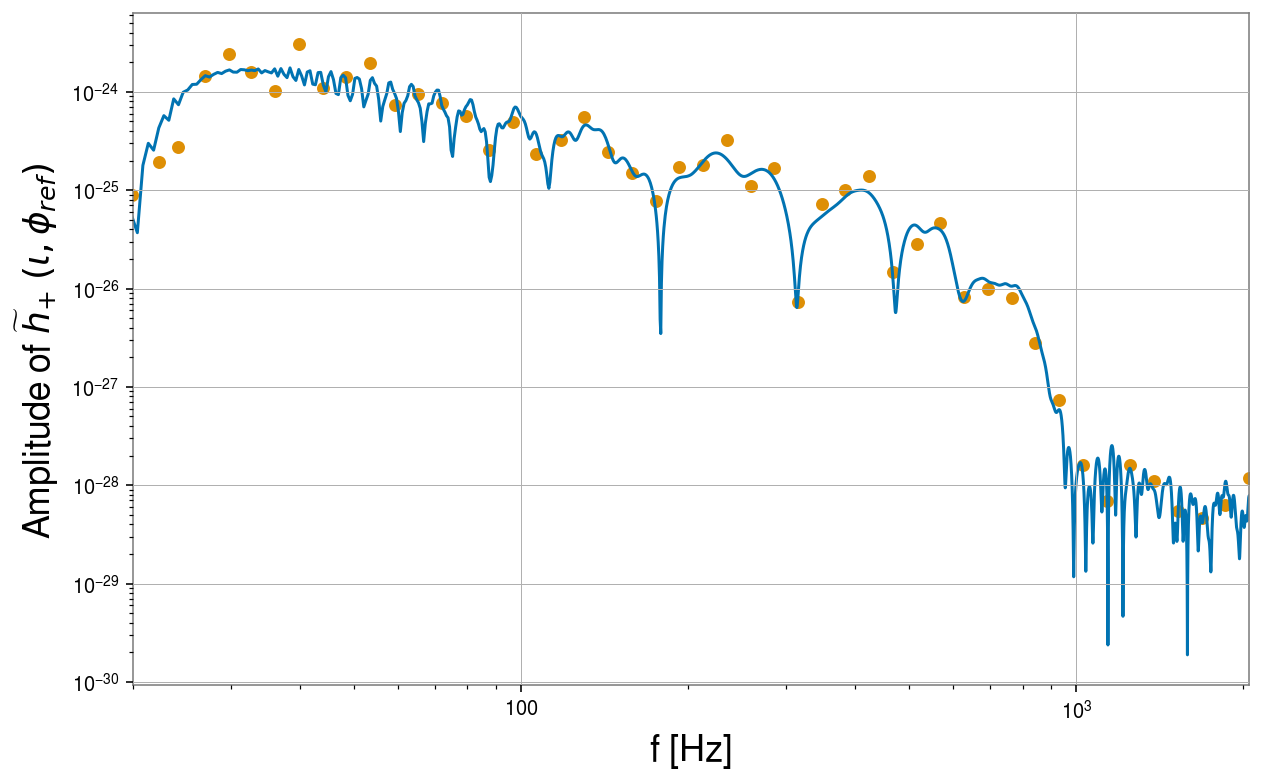

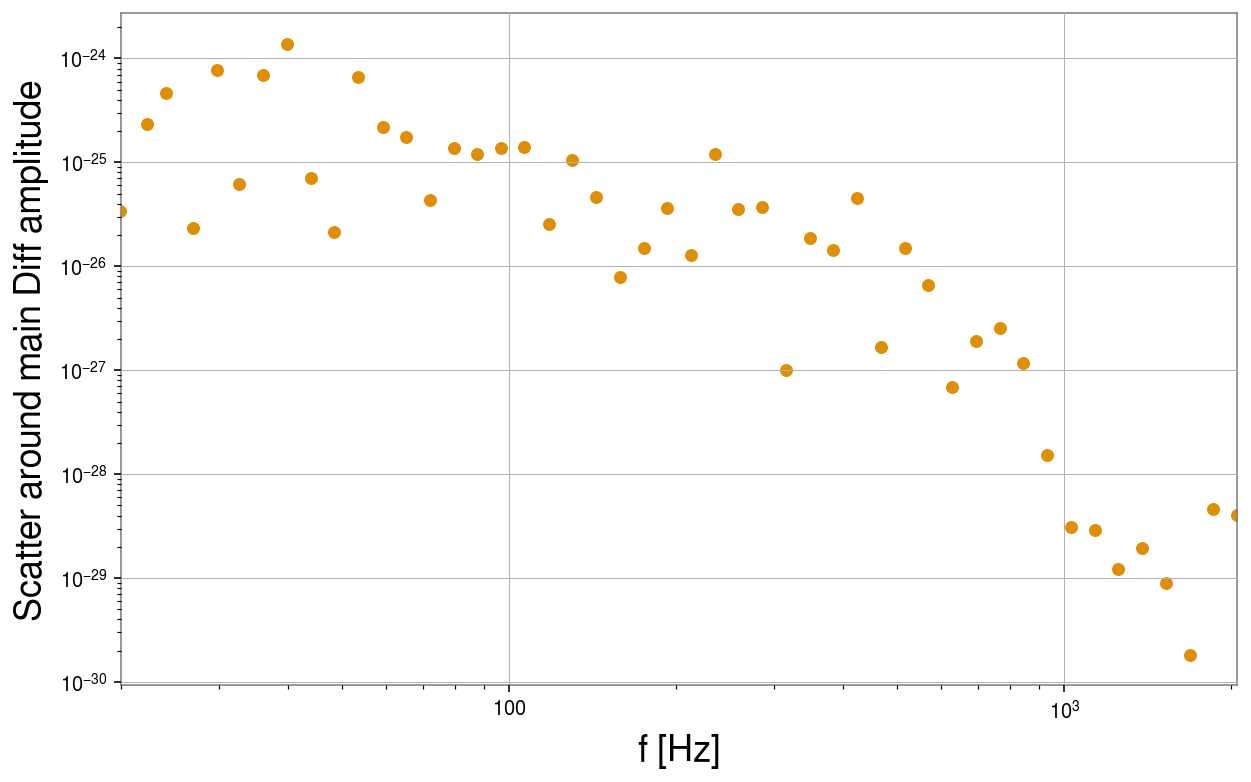

In [18]:
plt.loglog(h_plus_diff_freq, Raw_diff_amp, c=cp[0])

plt.scatter(h_plus_diff_freq[f_select_array_indeces], Amp_Gauss[:,0], color=cp[1], s=30)

plt.ylabel('Amplitude of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)

plt.show()

plt.scatter(h_plus_diff_freq[f_select_array_indeces], np.absolute(Raw_diff_amp[f_select_array_indeces] - Amp_Gauss[:,0]), color=cp[1], s=30)

plt.xlabel('f [Hz]', fontsize=18)
plt.ylabel('Scatter around main Diff amplitude', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
plt.xscale('log')
plt.yscale('log')
plt.show()

Scatter for the phase

Note that the scatter isn't typically bigger than 2 radians away from the "true diff" (this is of course because we defined it that way :P )

Also, the scatter is defined independently for each point, there's no assumed correlation between adjacent points for now.

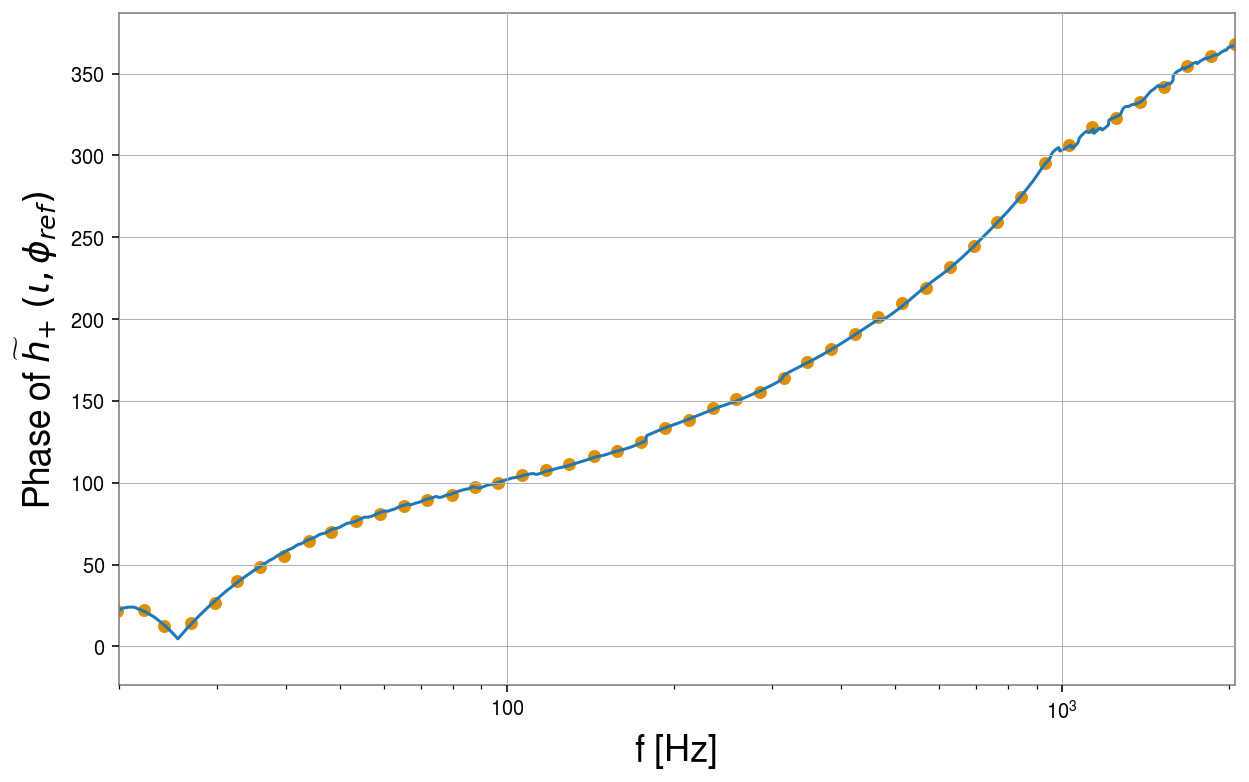

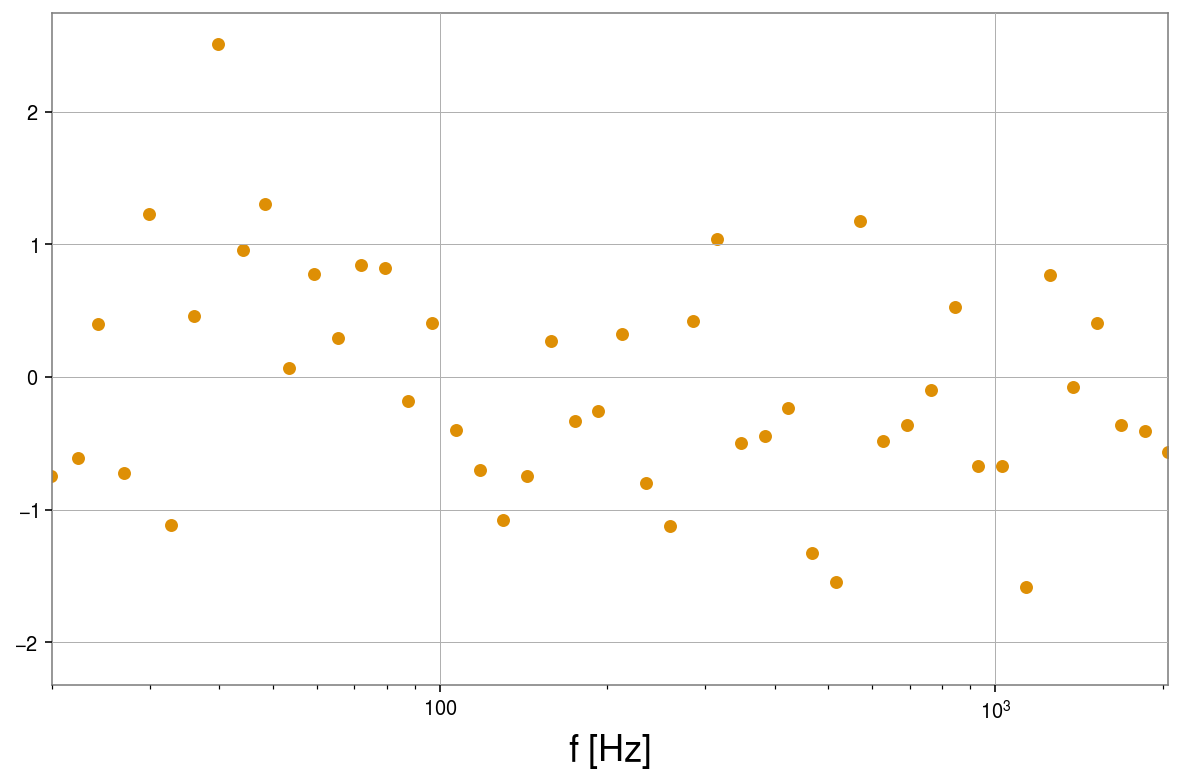

In [19]:
plt.semilogx(h_plus_diff_freq, Raw_diff_phase)
plt.scatter(h_plus_diff_freq[f_select_array_indeces], Phase_Gauss[:,0], color=cp[1], s=30)
plt.ylabel('Phase of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)

plt.show()

plt.scatter(h_plus_diff_freq[f_select_array_indeces], Raw_diff_phase[f_select_array_indeces] - Phase_Gauss[:,0], color=cp[1], s=30)
plt.xscale('log')
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
plt.show()

Put the amplitude and phase models together.

Here we do the actual cubic interpolation back from the scatter points to the full frequency array the WF is defined for.

In [20]:
Freq_domain_diffs = np.zeros((Ndraws, len(h_plus_diff_freq)), dtype=complex)

for i in tqdm(range(Ndraws)):
    amp_interpolant = interpolate.interp1d(h_plus_diff_freq[f_select_array_indeces], Amp_Gauss[:,i], kind='cubic', bounds_error=False, fill_value = 0.)
    
    phase_interpolant = interpolate.interp1d(h_plus_diff_freq[f_select_array_indeces], Phase_Gauss[:,i], kind='cubic', bounds_error=False, fill_value = 0.)
    
    #interpolated_unwrapped_phase = (phase_interpolant(h_plus_diff_freq) + np.pi) % (2 * np.pi) - np.pi
        
    Freq_domain_diffs[i] = amp_interpolant(h_plus_diff_freq)*np.exp(1j*phase_interpolant(h_plus_diff_freq))


100%|██████████| 10/10 [00:00<00:00, 73.47it/s]


Then do an iFFT back to the time-domain diff waveforms we all know and love

In [21]:
Time_domain_diffs = np.zeros((Ndraws, len(h_plus_diff)))

for i in tqdm(range(Ndraws)):
    Time_domain_diffs[i] = infft(frequency_domain_strain=Freq_domain_diffs[i], sampling_frequency=1/dt)

100%|██████████| 10/10 [00:00<00:00, 516.88it/s]


100%|██████████| 10/10 [00:00<00:00, 318.98it/s]


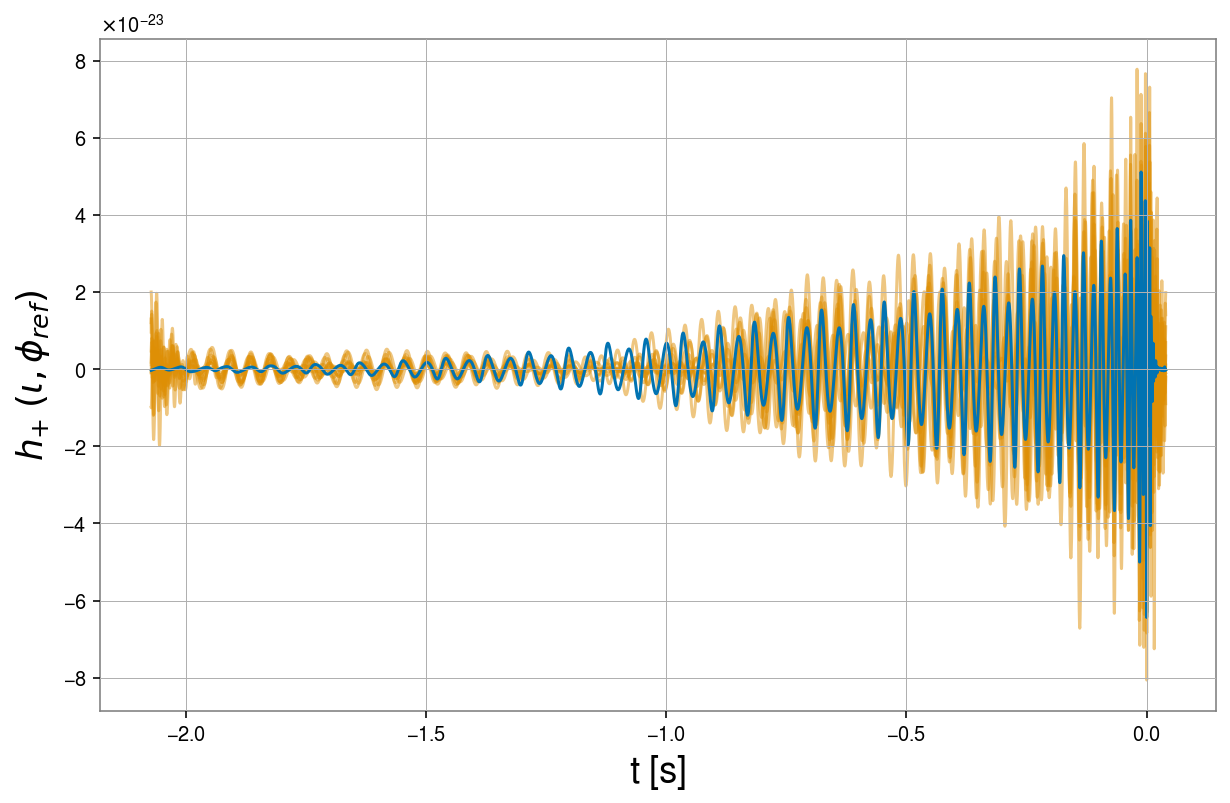

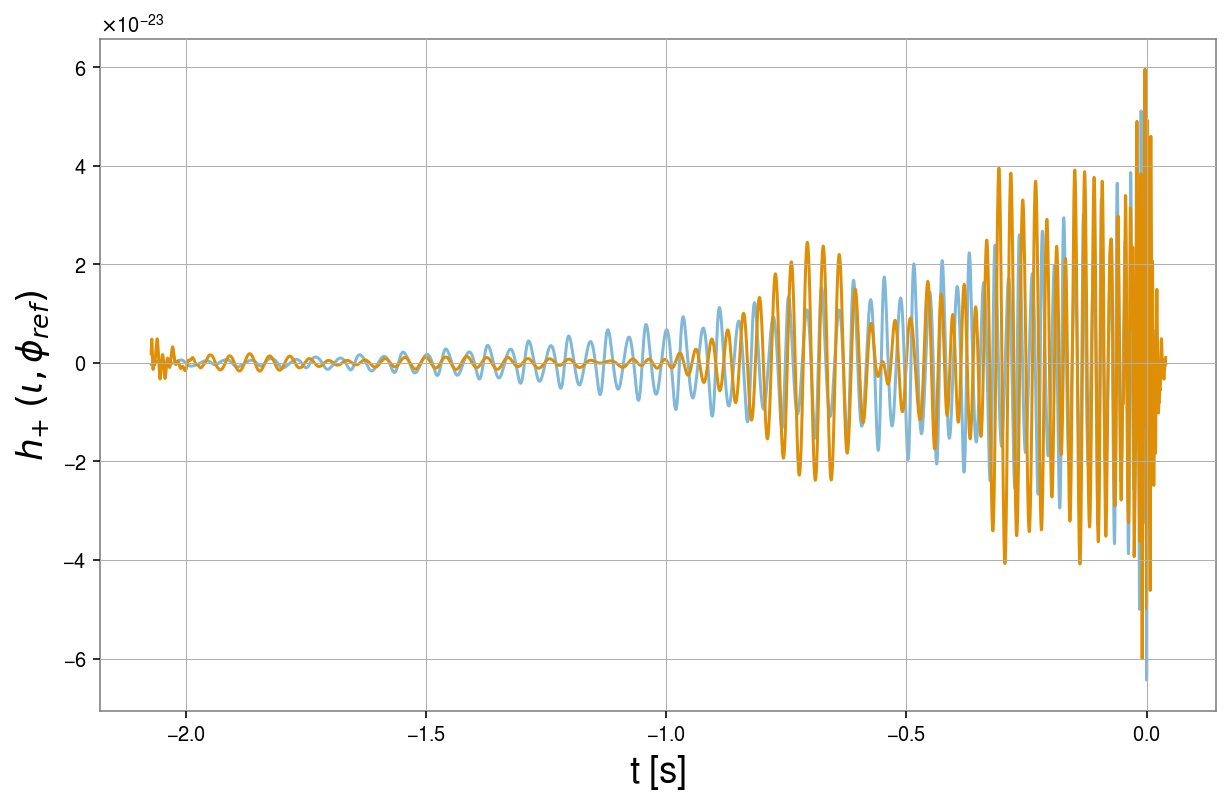

In [22]:
for i in tqdm(range(Ndraws)):
    plt.plot(t, Time_domain_diffs[i], label='diff_'+str(i), c=cp[1], alpha=0.5)

#plt.legend(loc='best')
plt.ylabel('$h_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('t [s]', fontsize=18)
plt.plot(t, h_plus_diff, label='diff', c=cp[0])
#plt.xscale('log')
#plt.ylim(-1e-22, 1e-22)
plt.show()

plt.plot(t, h_plus_diff, label='diff', c=cp[0], alpha=0.5)
plt.plot(t, Time_domain_diffs[0], label='diff_'+str(i), c=cp[1], alpha=1)
#plt.legend(loc='best')
plt.ylabel('$h_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('t [s]', fontsize=18)

#plt.xscale('log')
#plt.ylim(-1e-22, 1e-22)
plt.show()

This looks ok I think!

One concern I have though is the spike at the beginning of the WF...

I'm pretty sure it's not caused by FFT effects, but I doesn't have a real justification for it yet.

Also, it seems to not really "ring down" very much at the end, but that might be fine since this is only the diff.

In [23]:
h_plus_MargOverDiff = h_trunc.real + Time_domain_diffs[0]

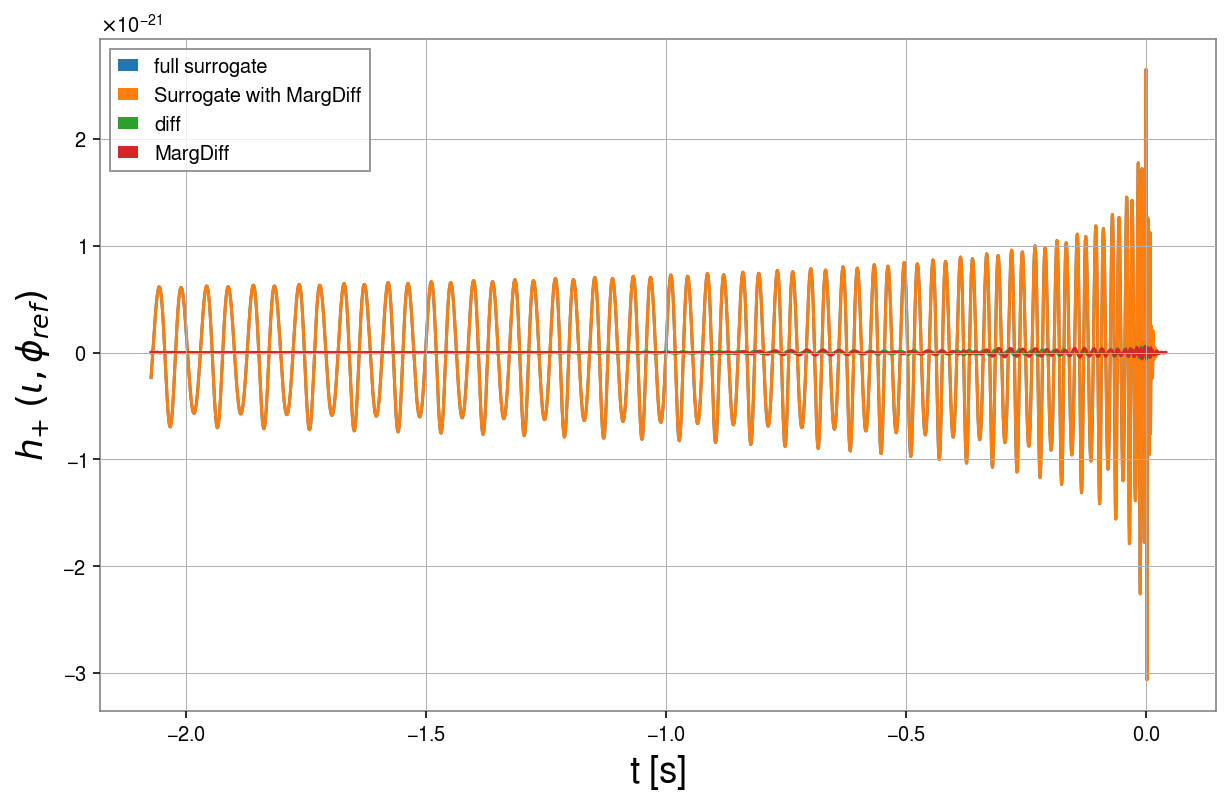

In [24]:
plt.plot(t, h.real, label='full surrogate')
plt.plot(t_trunc, h_trunc.real, label='Surrogate with MargDiff')
plt.plot(t, h_plus_diff, label='diff')
plt.plot(t, Time_domain_diffs[0], label='MargDiff')
plt.legend(loc='best')
plt.ylabel('$h_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('t [s]', fontsize=18)
plt.show()

In [25]:
h_plus_Full_fft, h_plus_Full_freq = nfft(h.real, sampling_frequency=1/dt)
Raw_Full_phase = np.unwrap(np.angle(h_plus_Full_fft))

In [26]:
Time_domain_TruncPlusDiffs = np.zeros((Ndraws, len(h_plus_diff)))
Time_domain_TruncPlusDiffs_rawPhase = np.zeros((Ndraws, len(Raw_Full_phase)))

for i in tqdm(range(Ndraws)):
    Time_domain_TruncPlusDiffs[i] = h_trunc.real + Time_domain_diffs[i]
    h_plus_TruncPlusDiffs_fft, h_plus_TruncPlusDiffs_freq = nfft(Time_domain_TruncPlusDiffs[i], sampling_frequency=1/dt)
    Time_domain_TruncPlusDiffs_rawPhase[i] = np.unwrap(np.angle(h_plus_TruncPlusDiffs_fft))

100%|██████████| 10/10 [00:00<00:00, 395.98it/s]


100%|██████████| 10/10 [00:00<00:00, 318.92it/s]


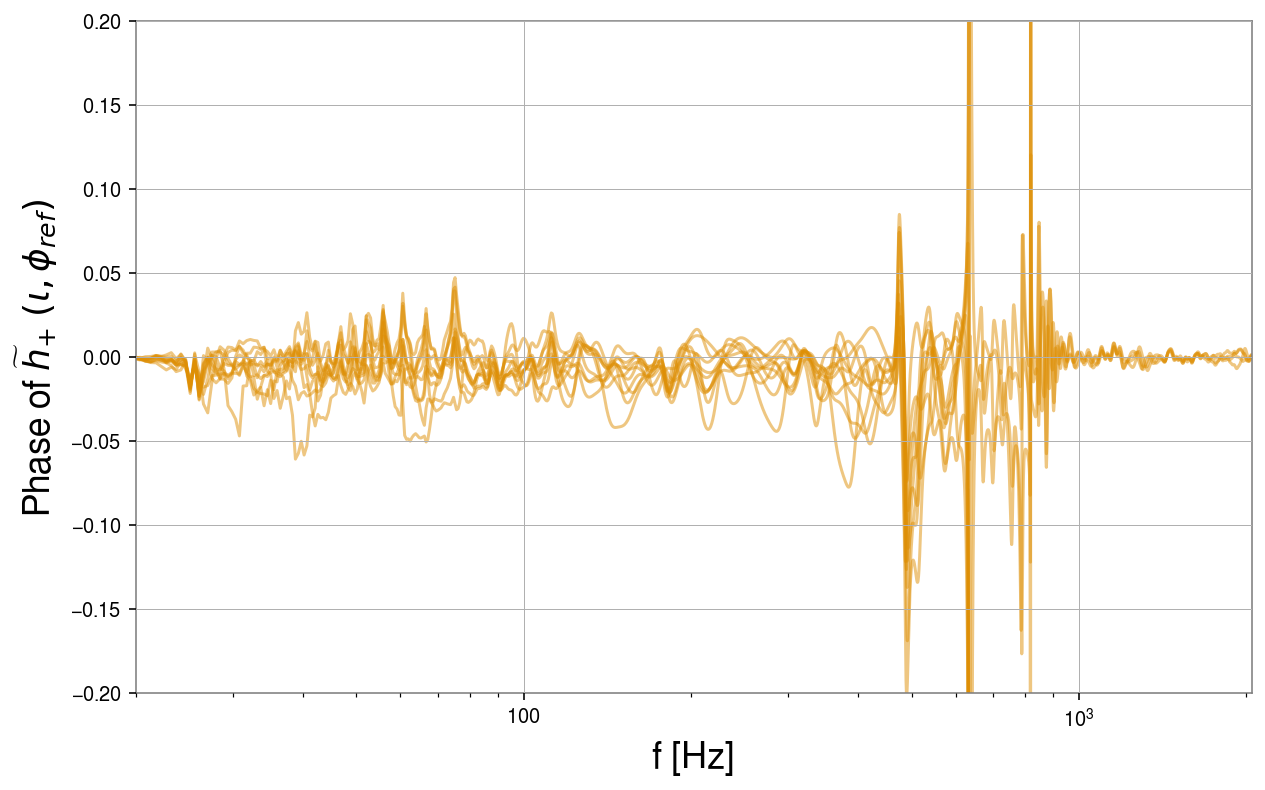

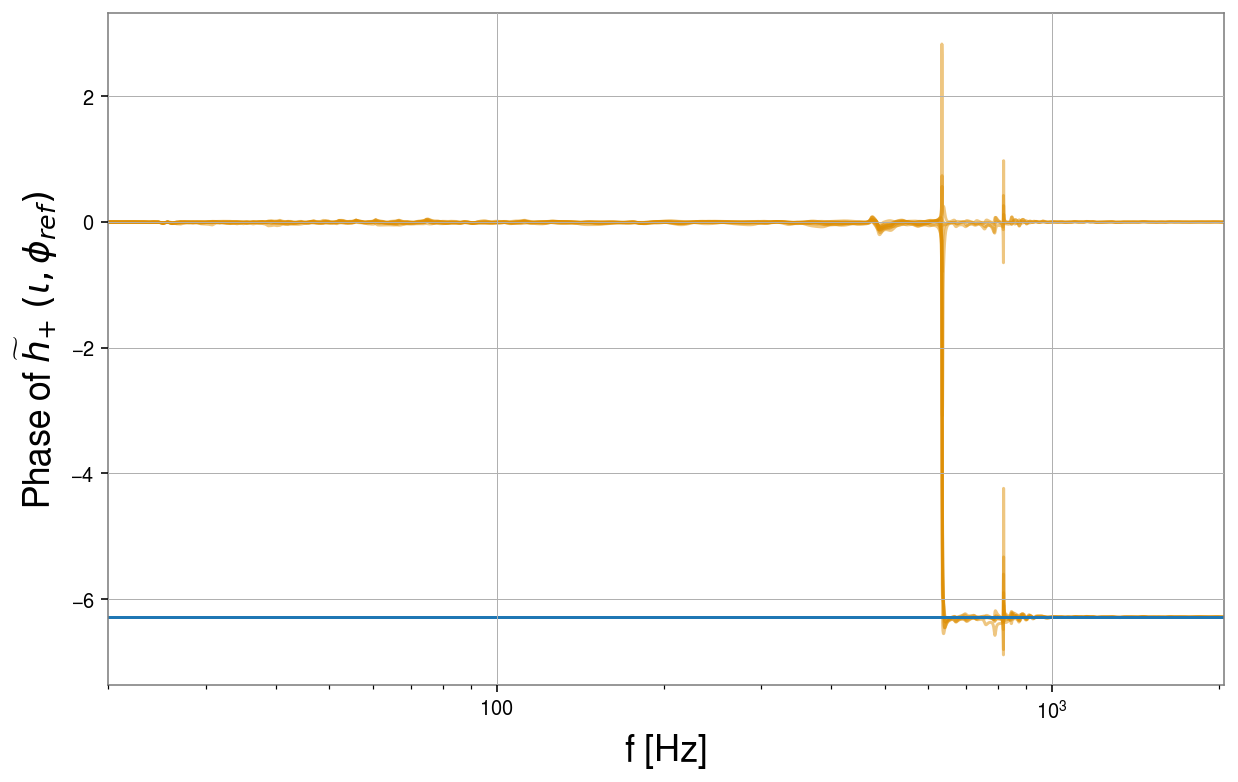

In [27]:
for i in tqdm(range(Ndraws)):
    plt.semilogx(h_plus_Full_freq, Time_domain_TruncPlusDiffs_rawPhase[i] - Raw_Full_phase, label='diff_'+str(i), c=cp[1], alpha=0.5)

plt.ylabel('Phase of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
plt.ylim(-0.2,0.2)
plt.show()

for i in range(Ndraws):
    plt.semilogx(h_plus_Full_freq, Time_domain_TruncPlusDiffs_rawPhase[i] - Raw_Full_phase, label='diff_'+str(i), c=cp[1], alpha=0.5)

plt.ylabel('Phase of $\widetilde{h}_{+}$ $(\iota, \phi_{ref})$', fontsize=18)
plt.xlabel('f [Hz]', fontsize=18)
plt.xlim(f_low, (1/dt)/2)
#plt.ylim(-0.3,0.3)
plt.axhline(-2*np.pi)
plt.show()